In [3]:
from __future__ import annotations
import pickle
import numpy as np
from edpyt.dmft import DMFT, Gfimp
from edpyt.nano_dmft import Gfimp as nanoGfimp
from scipy.interpolate import interp1d
from edpyt.nano_dmft import Gfloc

from ase.units import kB
import matplotlib.pyplot as plt
import os


In [9]:
def plot(gf, z_ret, semilogy=True):
    w = z_ret.real
    dos = -1 / np.pi * gf(z_ret).sum(axis=0).imag

    fig, ax = plt.subplots()
    if semilogy:
        ax.semilogy(w, dos)
    else:
        ax.plot(w, dos)

    ax.set_xlabel("Energy [eV]")
    ax.set_ylabel("DOS [a.u.]")
    ax.tick_params(axis="x", which="both", bottom=True, top=False, labelbottom=True)

    return ax


In [28]:
data_folder = "output/lowdin"
H_active = np.load(f"{data_folder}/bare_hamiltonian.npy").real
eigvals = np.load(f"{data_folder}/eigvals_Hbare.npy")
occupancy_goal = np.load(f"{data_folder}/occupancies.npy")
z_mats = np.load(f"{data_folder}/matsubara_energies.npy")
# z_ret = np.load(f"{data_folder}/retarded_energies.npy")

len_active = occupancy_goal.size
nimp = len_active
temp = 9
beta = 1 / (kB * temp)
mu = 0.0
S_active = np.eye(len_active)
idx_neq = np.arange(len_active)
idx_inv = np.arange(len_active)
eta = 1e-4
energies = np.arange(-7, 10, 0.01)
z_ret = energies + 1j * eta

Sigma = lambda z: np.zeros((nimp, z.size), complex)

hyb_mats = np.fromfile(
    f"{data_folder}/matsubara_hybridization.bin", complex
).reshape(
    z_mats.size,
    len_active,
    len_active,
)
_HybMats = interp1d(
    z_mats.imag, hyb_mats, axis=0, bounds_error=False, fill_value=0.0
)
HybMats = lambda z: _HybMats(z.imag)

gfloc0 = Gfloc(
    H_active, S_active, HybMats, idx_neq, idx_inv, nmats=z_mats.size, beta=beta
)
gfloc0.update(mu=mu)
gfloc0.set_local(Sigma)

(-3.0, 3.0)

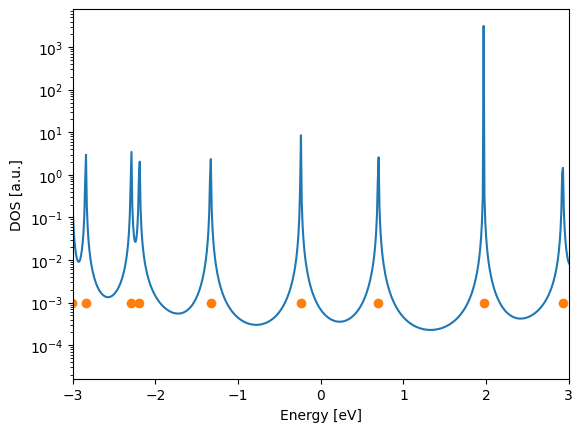

In [30]:
ax = plot(gfloc0, z_ret, semilogy=True)
ax.plot(eigvals, 1e-3*np.ones(len_active), 'o')
plt.xlim(-3,3)